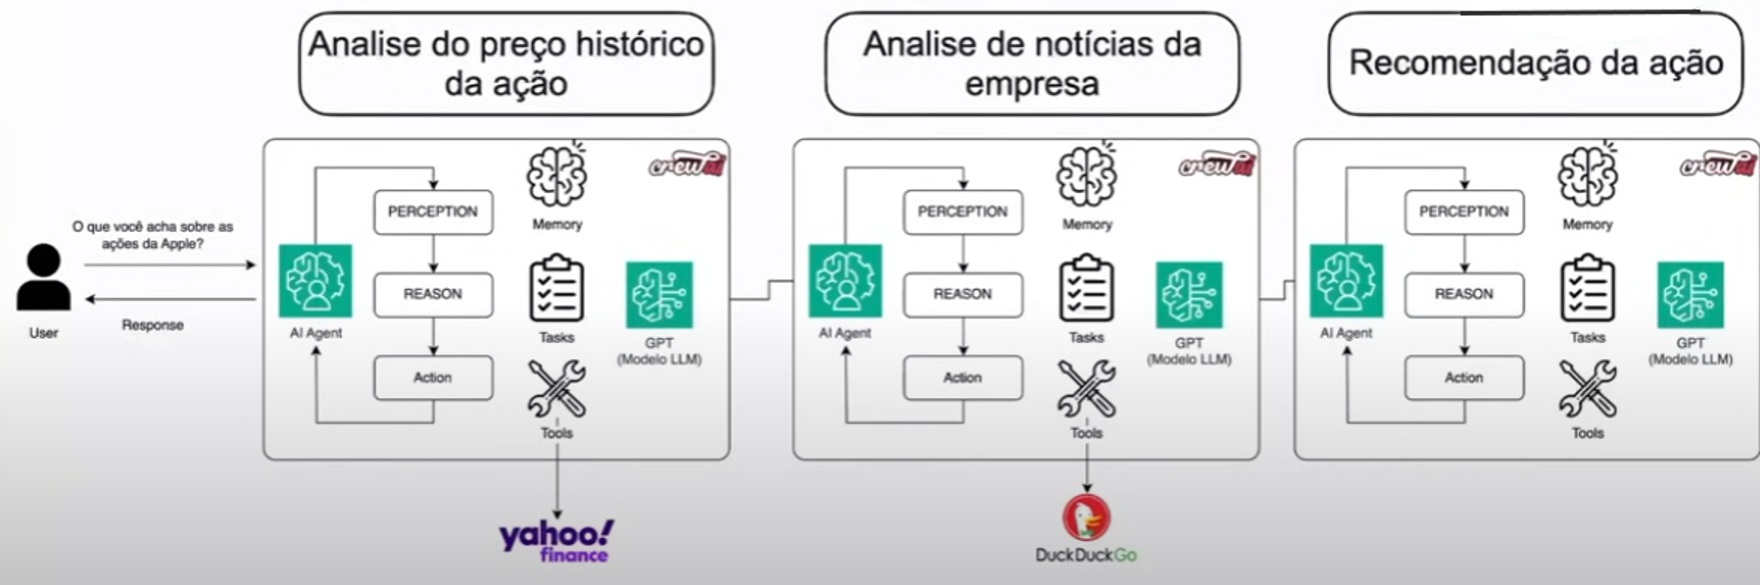

In [1]:
#instalação
!pip install yfinance==0.2.41
!pip install crewai==0.28.8
!pip install 'crewai[tools]'
!pip install langchain==0.1.20
!pip install langchain-openai==0.1.7
!pip install langchain-community==0.0.38

ERROR: Invalid requirement: "'crewai[tools]'": Expected package name at the start of dependency specifier
    'crewai[tools]'
    ^


In [2]:
import json
import os
from datetime import datetime

import yfinance as yf

from crewai import Agent, Task, Crew, Process

from langchain.tools import Tool
from langchain_openai import ChatOpenAI
from langchain_community.tools import DuckDuckGoSearchResults


Utilizando a lib do yahoo o method download precisamos passar o ticket que é a sigla da ação na bolsa e duas datas do intervalo que queremos retornar, e com o tools costruirmos um tools(ferramentas)

In [3]:
# CRIANDO YAHOO FINANCE TOOL
def fetch_stock_price(ticket):
    stock = yf.download(ticket, start="2023-08-08", end="2024-08-08")
    return stock

yahoo_finance_tool = Tool(
     name = "yahhoo Finance Tool",
     description = "Fetches stocks prices for {ticket} from the last year about a specific company from Yahoo Finance Tools",
     func = lambda ticket:  fetch_stock_price(ticket)
 )

In [15]:
# IMPORTANDO OPENAI LLM - GPT
OPENAI_API_KEY = ""
llm = ChatOpenAI(model="gpt-3.5-turbo", openai_api_key=OPENAI_API_KEY)


- O primeito agente de ia vai fazer uma analise do preço historico este agente tem suas etapas de PERCEPTION, REASON , ACTION, MEMORY, TASKS, TOOLS(Yahoo! finance) utilizando o modelo do gpt tudo forneccido pela crewai e seus metodos 

In [16]:
stockPriceAnalyst = Agent(
    role = "senior stock price Analyst",
    goal = "Find the {ticket} stock price and analyses trends",
    backstory = """ you're highly experienced in analyzing the price of an specific stock 
    and make predictions about its future price.""",
    verbose = True,
    llm = llm,
    max_iter = 5,
    memory = True,
    tools = [yahoo_finance_tool],
    allow_delegation = False
)

In [17]:
getStockPrice = Task(
    description = "Analyze the stock {ticket} price history and create a trend analyses of up, down or sideways",
    expected_output = """ Specify the current trend stock price  - up, down or sideways.
    eg. stock = 'APPL, price UP' """,
    agent = stockPriceAnalyst
)

### O segundo agente de ia vai fazer uma analise de noticias da empresa utilizando com TOOLS(Duck Duck Go) pra fazer uma pesquina na internet 

In [18]:
# Importando a tool de search
search_tool = DuckDuckGoSearchResults(backend='news', num_results=10)

In [19]:
newsAnalyst = Agent(
    role = "Stock News Analyst",
    goal = """Create a short summary of the market news related to the stock {ticket} company. Specify the current trend - up, down or sideways with the news context. For each request stock asset, specify a 
    numbet between 0 and 100, where 0 is extreme fear and 100 is extreme greed""",
    backstory = """ you're highly experienced in analyzing the market trends and news and have tracked assest for more then 10 years.
    you're also master level analyts in the tradicional markets and have deep understanding of human psychology.
    You understand news, theirs tittles and information, but you look at those with a health dose of shepticism.
    you consider also the source of the news articles.
      """,
    verbose = True,
    llm = llm,
    max_iter = 10,
    memoory = True,
    tools = [search_tool],
    allow_delegation = False
)

In [20]:
get_news = Task(
    description = """Take the stock and always include BTC to it (if not request).
    Use the search tool to search each one individually.
    The current date is .
    compose the results into a helpfull repost 
    """,
    expected_output = """ A summary of the overall market and one sentence summary for each request asset.
     Include a fear/greed score for each asset based on the news. Use format:
     <STOCK ASSET>
     <SUMMARY BASED ON NEWS>
     <TREND PREDICTION>
     <FEAR/ GREED SCORE>
      """,
    agent = newsAnalyst
)

O terceiro agente de ia vai fazer uma avaliação e realizar a recomendação 

In [21]:
stockAnalystWrite = Agent(
    role = "Senior Stock analyts Write",
    goal = """Analyze the trends price and news and write an insighfull compelling and informative 3 paragraph long newsletter based on the stock report and price trend.""",
    backstory = """ You're widely accepted as the best stock analyst in the market. You understand concepts and create compelling stories
    and narratives that resonate with wider audiences.

    you understand macro factors and combine multiple theories - eg. cycle theory and fundamental analyses.
    you're able to hold multiple opinions when analyzing anything. 

      """,
    verbose = True,
    llm = llm,
    max_iter = 10,
    memoory = True,
    tools = [yahoo_finance_tool],
    allow_delegation = True
)

In [22]:
writeAnalyses = Task(
    description = """Use the stock price trend and the stock news report to create an analyses and write the newsletter about the {ticket} company
    that is brief and highlights the most important points.
    Focus on the stock price trend, news and fear/greed score. What are the near future consideration?
    Include the previous analyses of stock trend and news summary """,
    expected_output = """An eloquent 3 paragraphs newsletter formated as markdown in an easy readable manner. It should contain:
    
    - 3 bullets executive summary
    - Introduction - set the overall picture and spike up the interest
    - main part prpviders the meat of the analysis including the news summary and fead/greed socres
    - summary - key facts and concrete future trend prediction - up down or sideways.
    -""",
    agent = stockAnalystWrite,
    context = [getStockPrice, get_news]
)

In [23]:
crew = Crew(
     agents= [stockPriceAnalyst, newsAnalyst, stockAnalystWrite],
     tasks = [getStockPrice, get_news, writeAnalyses],
     verbose = 2,
     process= Process.hierarchical,
     full_output=True,
     share_crew=False,
     manager_llm=llm,
     max_iter=15

)

2024-10-07 11:26:17,325 - 26228 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


In [25]:
result = crew.kickoff(inputs={'ticket': 'AAPL'})

 [DEBUG]: Working Agent: Crew Manager
 [INFO]: Starting Task: Analyze the stock AAPL price history and create a trend analyses of up, down or sideways


> Entering new CrewAgentExecutor chain...
I need to gather information on the stock AAPL price history and create a trend analysis to determine if the current trend is up, down, or sideways. I should delegate tasks to my team members and ask them questions to get the best possible outcome.

Action: Delegate work to co-worker
Action Input: 
{
  "coworker": "Senior Stock Price Analyst",
  "task": "Analyze AAPL stock price history",
  "context": "I need you to analyze the historical stock price data of AAPL to determine any trends in the price movement."
}

> Entering new CrewAgentExecutor chain...
I should use the Yahoo Finance Tool to fetch the historical stock price data for AAPL and analyze any trends in the price movement.

Action: yahhoo Finance Tool
Action Input: {"ticket": "AAPL"}

> Entering new CrewAgentExecutor chain...
I need 

In [26]:
list(result.keys())

['final_output', 'tasks_outputs']

In [27]:
result['final_output']

"### Apple Inc. (AAPL) Newsletter Analysis\n\n**Executive Summary:**\n- Mixed market sentiment with positive analyst ratings but concerns about iPhone sales and AI feature delays.\n- Analysts revising stock target amid high iPhone 16 expectations.\n- Apple's stock price may experience fluctuations in the near future.\n\n**Introduction:**\nThe recent developments surrounding Apple Inc. (AAPL) have created a mixed sentiment among investors and analysts. With news of Warren Buffett selling half of Apple shares and concerns about iPhone sales and AI feature delays, the stock market is closely watching AAPL's movements.\n\n**Main Analysis:**\nRecent news updates highlight the varying opinions on AAPL's future. Analysts from J.P. Morgan and Bank of America maintain a Buy rating, but adjustments are being made due to lower iPhone 16 demand and concerns about lead times. The unveiling of AI-enhanced Macs and Apple's achievement of becoming a $3 trillion company add layers to the stock's narrat

In [28]:
fetch_stock_price('AAPL')


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-08-08,179.690002,180.270004,177.580002,179.800003,178.643372,67823000
2023-08-09,180.869995,180.929993,177.009995,178.190002,177.043762,60378500
2023-08-10,179.479996,180.750000,177.600006,177.970001,176.825165,54686900
2023-08-11,177.320007,178.619995,176.550003,177.789993,176.884857,51988100
2023-08-14,177.970001,179.690002,177.309998,179.460007,178.546371,43675600
...,...,...,...,...,...,...
2024-08-01,224.369995,224.479996,217.020004,218.360001,218.107544,62501000
2024-08-02,219.149994,225.600006,217.710007,219.860001,219.605804,105568600
2024-08-05,199.089996,213.500000,196.000000,209.270004,209.028061,119548600


In [29]:
len(result['tasks_outputs'])

3